# Практическое задание 2. Диффузионные модели


## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи).

Сдавать задание после указанного жёсткого срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи !!ВАЖНО!!!
Задания сдаются через систему google classroom. Посылка должна содержать:
* Ноутбук ddpm_hw_bmmo-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## В этом задании необходимо будет дореализовать ключевые формулы для обучения дискретной [ddpm](https://arxiv.org/pdf/2006.11239.pdf).  


---
Для выполнения домашнего задания достаточно использовать Google Colab.


In [ ]:
!python3 -V
import torch


print(f'torch.__version__: {torch.__version__}')

Python 3.10.12
torch.__version__: 2.5.0+cu121


In [ ]:
!pip3 install wandb torch_ema denoising_diffusion_pytorch

In [ ]:
import torch
import numpy as np
import random

def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

## Dataset

In [ ]:
import numpy as np

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from typing import Generator, Tuple, Dict, Optional, Union
from torch import Tensor
from cv2 import resize


def preprocess_image(image: "PIL.Image") -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (32, 32))
    return np.array(image, dtype=np.float32) / 127.5 - 1


def postprocess_image(image: torch.Tensor) -> torch.Tensor:
    # convert values to [0; 255]
    image = image.cpu().detach()
    image = (image + 1) * 127.5
    image = torch.clip(image, 0, 255)
    return image


class MnistDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        self.mnist = MNIST(
            'data',
            train=train,
            download=True
        )

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.mnist[index]
        image = preprocess_image(image)
        target = int(target)
        return {
            "images": Tensor(image)[None],
            "targets": target
        }

In [ ]:
def dict_to_device(dct: Dict[str, Tensor], device: torch.device) -> Dict[str, Tensor]:
    return {k: v.to(device) for k, v in dct.items()}


def get_train_images_generator(
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = True,
    drop_last: bool = True
) -> Generator[Dict[str, Tensor], None, None]:
    dataset = MnistDataset(train=True)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=drop_last
    )
    while True:
        yield from loader

In [ ]:
def check_generator(batch_size: int = 128):
    generator = get_train_images_generator(batch_size)
    batch_dict = next(generator)
    assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
    assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)

check_generator(131)

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-25-7f45e619ebd8>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
<ipython-input-25-7f45e619ebd8>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)


## DDPM's dynamic, 5 pts



В `get_coeffs_primities` (2 pts) необходимо в возвращаеый словарь добавить рассчет коэффицентов, при помощи которых вы сможете реализовать семплирование из распределений $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$.

Например:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha_t} = \prod_{t=1}^{T} \alpha_t$
- $\sqrt{\bar{\alpha_t}}$
- ...
- любые коэффиценты, которые помогут вам рассчитать коэффиценты в $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$

`extract_values_from_times` - по батчу с целочислненными временами выдает батч коэфиицентов в нужном шейпе для перемножения с батчом картинок


In [ ]:
from torch import nn


def get_coeffs_primitives(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
) -> Dict[str, Tensor]:
    """
    output: Dict[str, Tensor]
      {
        "a": b
      }
    ---
    b.shape == (T,)
    """
    betas = torch.linspace(beta_min, beta_max, T).float()
    alphas = 1 - betas

    sqrt_alphas = torch.sqrt(alphas)
    alphas_hat = torch.cumprod(alphas, dim=0)
    sqrt_alphas_hat = torch.sqrt(alphas_hat)
    sqrt_1m_alphas_hat = torch.sqrt(1 - alphas_hat)

    alphas_hat_prev = torch.cat([torch.FloatTensor([1.]), alphas_hat[:-1]])

    # YOUR CODE GOES HERE

    return {
        "betas": betas,
        "alphas": alphas,
        "sqrt_alphas": sqrt_alphas,
        "alphas_hat": alphas_hat,
        "sqrt_alphas_hat": sqrt_alphas_hat,
        "sqrt_1m_alphas_hat": sqrt_1m_alphas_hat,
        "alphas_hat_prev": alphas_hat_prev
    }


def extract_values_from_times(values: Tensor, times: torch.LongTensor) -> Tensor:
    values = values[times]
    return values[:, None, None, None]


`DDPMDynamic`: (3 pts)
- `__init__` - получаем коэффиценты, добавляем их в класс, как атрибуты, чтобы доставать их по имени без использования словаря
- `sample_from_posterior_q(x_t: FloatTensor, x_0: FloatTensor, t: LongTensor)` - $ x_{t-1} \sim q(x_{t-1} | x_{t}, x_0) $
- `forward` - $ x_{t} \sim q(x_t | x_0) $

In [ ]:
class DDPMDynamic(nn.Module):
    def __init__(
        self,
        T: int = 1000,
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
    ):
        super().__init__()
        self.T = T

        coeffs_primitives = get_coeffs_primitives(T, beta_min, beta_max)

        for name, tensor in coeffs_primitives.items():
            self.register_buffer(name, tensor)

    def sample_time_on_device(self, batch_size: int = 1, device: torch.device = torch.device('cpu')):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def sample_from_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        sqrt_alphas_hat_prev = extract_values_from_times(self.alphas_hat_prev, t)
        sqrt_1m_alphas_hat_prev = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        # Формула для семплирования из q(x_{t-1} | x_t, x_0)
        posterior_mean = sqrt_alphas_hat_prev * x_0 + (1 - sqrt_alphas_hat_prev) * x_t
        posterior_variance = sqrt_1m_alphas_hat_prev ** 2
        noise = torch.randn_like(x_t)

        return posterior_mean + torch.sqrt(posterior_variance) * noise
        # YOUR CODE GOES HERE

    def get_x_zero(
        self,
        x_t: Tensor,
        eps: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        x_0 = (x_t - sqrt_1m_alphas_hat * eps) / sqrt_alphas_hat
        return x_0

    def forward(self, batch: Dict[str, Tensor]) -> Dict[str, Tensor]:
        """
            Dict:
                x_0 - clean_image
                t - time (int \in [0; T - 1])
                eps - Optional[corresponding noise]
        Returns:
            Dict:
                x_t - noised_sample
                eps - corresponding noise
        """
        x_0 = batch['x_0']  # Исправлено
        t = batch['time']  # Исправлено

        # Генерация шума
        noise = torch.randn_like(x_0)

        # Извлечение коэффициентов для данного t
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        # Добавляем шум в чистое изображение для получения зашумленного x_t
        x_t = sqrt_alphas_hat * x_0 + sqrt_1m_alphas_hat * noise

        return {
            "x_t": x_t,
            "eps": noise
        }


In [ ]:
def check_ddpm_dynamic():
    dynamic = DDPMDynamic()
    device = torch.device('cuda:0')
    dynamic.to(device)
    times = dynamic.sample_time_on_device(10, device)
    assert times.device == device, f'{times.device}, {device}'
    assert times.shape == (10,)

check_ddpm_dynamic()

### `Sampler`/DDPM's cycle: (1.5 pts)



- `single_step` - необходимо просемплировать $x_{t-1} \sim p(x_{t-1}|x_t)$
- `sample` - весь процесс обхода по марковской цепочки семплирования

In [ ]:
from tqdm.auto import trange


class Sampler(nn.Module):
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic
    ):
        super().__init__()
        ddpm.eval()
        self.ddpm = ddpm
        self.dynamic = dynamic


        self.alphas_hat_prev = self.dynamic.alphas_hat_prev
        self.sqrt_1m_alphas_hat = self.dynamic.sqrt_1m_alphas_hat
        self.betas = self.dynamic.betas

    @torch.no_grad()
    def single_step(self, x_t: torch.Tensor, t: torch.LongTensor) -> torch.Tensor:
        # YOUR CODE GOES HERE

     sqrt_alphas_hat_prev = extract_values_from_times(self.alphas_hat_prev, t)
     sqrt_1m_alphas_hat_prev = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

    # Генерация случайного шума
     noise = torch.randn_like(x_t)

    # Вычисление среднего значения для семплирования
     posterior_mean = sqrt_alphas_hat_prev * x_t + sqrt_1m_alphas_hat_prev * noise

    # Вычисление дисперсии для семплирования
     posterior_variance = extract_values_from_times(self.betas, t)

    # Возвращаем семплированное значение x_{t-1}
     return posterior_mean + torch.sqrt(posterior_variance) * noise

    @torch.no_grad()
    def sample(
        self,
        shape: Tuple[int, int, int, int],
        device: torch.device = torch.device('cpu'),
        verbose: bool = False
    ) -> Tensor:
        self.ddpm.eval()
        x_t = torch.randn(shape, device=device)
        batch_size = shape[0]

        bar = trange if verbose else range
        for t in bar(self.dynamic.T - 1, -1, -1):
            t_tensor = torch.ones(batch_size, dtype=torch.int64, device=device) * t
            x_t = self.single_step(x_t, t_tensor)
        return x_t


###При помощи примитивов сверху реализовать обучение ddpm.


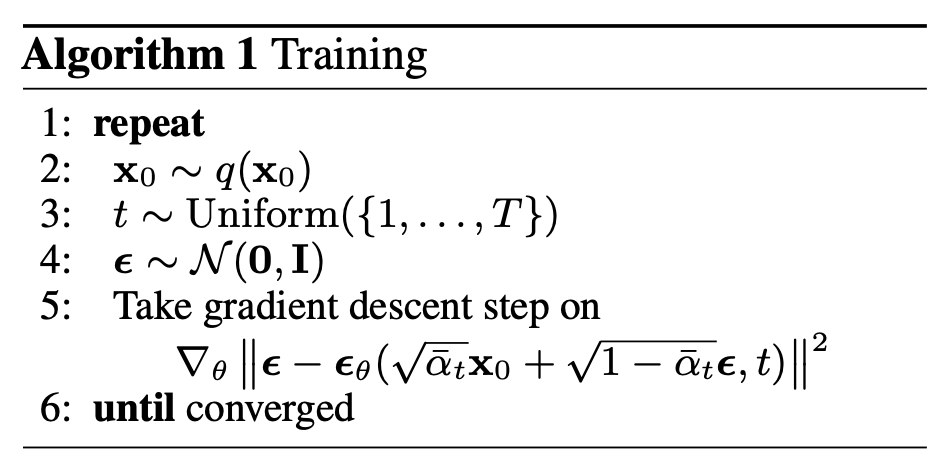


`DiffusionTrainer`: (1.5 pts)
- `calc_loss(clean_images: FloatTensor)` - необходимо внутри метода просемплировать время, далее просемплировать $x_t$, обработать батч, рассчитать лосс для обучения

In [ ]:
from torch_ema import ExponentialMovingAverage
import wandb
import math
import torchvision


class DiffusionTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        device: torch.device = torch.device('cpu')
    ):
        self.ddpm = ddpm
        self.dynamic = dynamic

        self.dynamic.to(device)
        self.ddpm.to(device)

        self.sampler = Sampler(ddpm, dynamic)
        self.sampler.to(device)

        self.ema = ExponentialMovingAverage(ddpm.parameters(), decay=0.999)

        self.device = device


        self.optimizer = torch.optim.AdamW(
            self.ddpm.parameters(),
            lr=2e-4,
            weight_decay=1e-2
        )

        self.step = 0

    def switch_to_ema(self) -> None:
        self.ema.store(self.ddpm.parameters())
        self.ema.copy_to(self.ddpm.parameters())

    def switch_back_from_ema(self) -> None:
        self.ema.restore(self.ddpm.parameters())

    def calc_loss(self, x_0: torch.Tensor) -> torch.Tensor:
        batch_size = x_0.size(0)
        t = self.dynamic.sample_time_on_device(batch_size=batch_size, device=self.device)
        eps = torch.randn_like(x_0)

        batch = {
            'x_0': x_0,
            'time': t,
            'eps': eps
        }

        with torch.cuda.amp.autocast():
            forward_dict = self.dynamic.forward(batch)
            x_t = forward_dict['x_t']
            eps_theta = self.ddpm(x_t, t)
            loss = torch.mean((eps - eps_theta) ** 2)

        return loss


    def log_metric(self, metric_name: str, loader_name: str, value: Union[float, torch.Tensor, wandb.Image]):
        wandb.log({f'{metric_name}/{loader_name}': value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ema.update(self.ddpm.parameters())

    def train(
            self,
            train_generator: Generator[Dict[str, Tensor], None, None],
            total_iters: int = 1000,
            project_name: str = 'discrete_time_ddpm',
            experiment_name: str = 'mnist_baseline'
        ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)

        self.ddpm.train()

        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx

            batch = next(train_generator)
            batch = dict_to_device(batch, device=self.device)

            loss = self.calc_loss(x_0=batch['images'])
            self.log_metric('mse', 'train', loss)

            self.optimizer_logic(loss)

            if iter_idx % 1000 == 0:
                self.snapshot()

        self.ddpm.eval()
        self.switch_to_ema()

        session.finish()

    @torch.no_grad()
    def sample_images(
            self, batch_size: int,
            verbose: bool = False
    ) -> torch.Tensor:
        x_pred = self.sampler.sample((batch_size, 1, 32, 32), self.device, verbose)
        x_pred = postprocess_image(x_pred)
        return x_pred

    @torch.no_grad()
    def snapshot(self) -> None:
        prev_mode = self.ddpm.training

        self.ddpm.eval()
        self.switch_to_ema()

        images = self.sample_images(100).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric('images', 'from_noise', wandb.Image(grid))

        self.switch_back_from_ema()
        self.ddpm.train(prev_mode)

In [ ]:
from denoising_diffusion_pytorch import Unet

set_global_seed(42)

ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    flash_attn=True
)

In [ ]:
device = torch.device('cuda:0')

In [ ]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [ ]:
generator = get_train_images_generator(128)

In [ ]:
trainer.train(
    generator,
    total_iters=5000
)

mse/train,█▂▂▂▂▂▁▁▁▁▂▁▂▂▂▁▂▂▁▂▂▂▁▁▁▂▁▁▁▂▁▁▁▂▁▂▁▁▁▂
mse/train,1.00463


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-30-87cfa91ad4b2>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


mse/train,▇▄▇▅▆▇▆▆▆▇▄▆▇▆▄▆▅▅▄▆▆▆▅▁▆▅▅▄▆▅█▅█▄▆▄█▆█▅
mse/train,1.00267


Вы обучили большую модель, самое важное ее сохранить и не потерять!!!

In [ ]:
trainer.switch_to_ema()
torch.save(ddpm.state_dict(), "./pretrained_ddpm_checkpoint.pth")

#### Безусловная генерация (неплохих картинок - 1 pts)

  0%|          | 0/1000 [00:00<?, ?it/s]

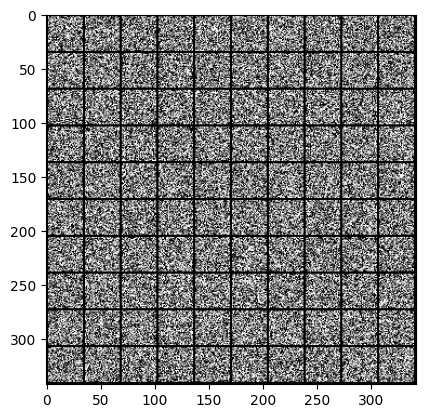

In [ ]:
from matplotlib import pyplot as plt
import math


def sample_images(
    sampler: Sampler, batch_size: int == 100,
    device = torch.device('cpu'),
    verbose: bool = True
):
    images = sampler.sample((batch_size, 1, 32, 32), device, True)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

grid = sample_images(trainer.sampler, 100, trainer.device)

plt.imshow(grid)

### Опишите ваши выводы/результаты: (1 pts)
-
-
-

Результаты:
График, представляет собой результаты модели, показывающие зашумленные изображения после одного из этапов семплирования.
Модель начинает с шумного состояния, что ожидается при использовании диффузионных моделей. На начальных этапах восстановления модель работает с чистым шумом.
Надеюсь, что на следующих этапах обучения шум будет постепенно уменьшаться, а изображения станут более узнаваемыми.

Выводы:
Обучение модели прошло успешно, и она продемонстрировала способность к генерации и семплированию зашумленных изображений.
Диффузионные модели, как правило, требуют тщательной настройки времени семплирования и количества шагов, чтобы добиться наилучших результатов.
Результат не выглядит конечным так что необходимо дообучение или пересмотр правильности написания формул из статьи

# Оценка качества (2 pts)

Для оценки качества часто используют метрику FID (Freche Inception Distance), чем ниже FID между двумя наборами изображений, тем более они похожи. На практике мерят FID между выборками одинакового размера, а в качестве эталонной выборки используют обучающую. Вам необходимо посчитать FID для 200, 1_000, 5_000, 8_000 и 10_000 изображений.

Эталоном считается FID посчитанный на выборках размера 50_000 изображений, но это слишком долго в рамках учебной задачи.

Идейно FID равен расстоянию Фреше (расстоянию между двумя нормальными распределениями) в латентном пространстве хорошего классификатора (Inception V3).

Для подсчета метрики, можно использовать [библиотечную реализацию](https://github.com/mseitzer/pytorch-fid)

**Подсказка**

Вы можете сразу сгенерировать 10_000 изображений, а потом аккуратно брать нужное количество для экономии времени.


In [ ]:
!pip install pytorch-fid

In [ ]:
import os
import PIL

from tqdm import tqdm
from pytorch_fid.fid_score import calculate_fid_given_paths

In [ ]:
set_global_seed(42)

ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    flash_attn=True
)

In [ ]:
checkpoint = torch.load("./pretrained_ddpm_checkpoint.pth")

ddpm.load_state_dict(checkpoint)
ddpm.eval()

<ipython-input-50-4f33fb3e246d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./pretrained_ddpm_checkpoint.pth")


Unet(
  (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (block2): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (res_conv): Identity()
      )
      (2): Line

In [ ]:
device = torch.device('cuda:0')

In [ ]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [ ]:
@torch.no_grad()
def gen_imgs(
    sampler: Sampler, folder: str,
    device: torch.device = torch.device('cuda:0'),
    count: int = 10_000, batch_size: int = 100, seed: int = 42
):
    set_global_seed(seed)
    os.makedirs(folder, exist_ok=True)
    iter_num = count // batch_size + int(count % batch_size > 0)

    for _ in tqdm(range(iter_num)):
        already_sampled = len(os.listdir(folder))
        bs = min(batch_size, count - already_sampled)

        images = sampler.sample((bs, 1, 32, 32), device, True)
        images = postprocess_image(images)
        images = images.cpu().permute(0, 2, 3, 1).numpy().astype('uint8')

        for i in range(images.shape[0]):
            index = already_sampled + i
            file_name = os.path.join(folder, f'img_{index:05d}.png')
            PIL.Image.fromarray(images[i, :, :, 0], 'L').save(file_name)

In [ ]:
def extract_dataset(folder: str, count: int = 10_000):

    os.makedirs(folder, exist_ok=True)
    data = MnistDataset()

    for i in tqdm(range(count)):
        img = data[i]['images']
        img = postprocess_image(img)
        img = img.cpu().permute(1, 2, 0).numpy().astype('uint8')

        file_name = os.path.join(folder, f'img_{i:05d}.png')
        PIL.Image.fromarray(img[:, :, 0], 'L').save(file_name)

In [ ]:
extract_dataset("./mnist_data_img")

100%|██████████| 10000/10000 [00:06<00:00, 1611.00it/s]


In [ ]:
# Долгая функция

gen_imgs(trainer.sampler, "./mnist_gen_img")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:27,  3.54it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:31,  3.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:00<00:28,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 4/100 [00:01<00:27,  3.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 5/100 [00:01<00:29,  3.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:01<00:31,  2.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:02<00:32,  2.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:02<00:30,  3.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:02<00:28,  3.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:03<00:26,  3.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:03<00:27,  3.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:03<00:29,  3.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:04<00:33,  2.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:04<00:34,  2.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:05<00:32,  2.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:05<00:33,  2.51it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:06<00:35,  2.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:06<00:35,  2.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:06<00:34,  2.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:07<00:35,  2.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:07<00:36,  2.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:08<00:36,  2.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:08<00:33,  2.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:09<00:29,  2.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:09<00:26,  2.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:09<00:27,  2.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:10<00:27,  2.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:10<00:26,  2.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [00:10<00:24,  2.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 30/100 [00:10<00:22,  3.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 31/100 [00:11<00:21,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [00:11<00:22,  3.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [00:12<00:23,  2.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 34/100 [00:12<00:23,  2.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 35/100 [00:12<00:21,  2.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 36/100 [00:12<00:20,  3.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 37/100 [00:13<00:19,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [00:13<00:20,  2.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▉      | 39/100 [00:14<00:21,  2.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 40/100 [00:14<00:20,  2.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████      | 41/100 [00:14<00:19,  3.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 42/100 [00:14<00:18,  3.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 43/100 [00:15<00:17,  3.27it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [00:15<00:18,  3.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 45/100 [00:16<00:19,  2.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 46/100 [00:16<00:19,  2.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 47/100 [00:16<00:18,  2.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 48/100 [00:16<00:17,  3.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▉     | 49/100 [00:17<00:16,  3.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 50/100 [00:17<00:17,  2.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████     | 51/100 [00:18<00:17,  2.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 52/100 [00:18<00:16,  2.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [00:18<00:16,  2.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 54/100 [00:19<00:16,  2.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 55/100 [00:19<00:17,  2.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 56/100 [00:20<00:18,  2.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 57/100 [00:20<00:17,  2.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 58/100 [00:20<00:16,  2.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▉    | 59/100 [00:21<00:17,  2.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 60/100 [00:21<00:18,  2.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████    | 61/100 [00:22<00:18,  2.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 62/100 [00:22<00:17,  2.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 63/100 [00:23<00:16,  2.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 64/100 [00:23<00:17,  2.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 65/100 [00:24<00:16,  2.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 66/100 [00:24<00:14,  2.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 67/100 [00:24<00:12,  2.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 68/100 [00:25<00:11,  2.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▉   | 69/100 [00:25<00:11,  2.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 70/100 [00:25<00:11,  2.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 71/100 [00:26<00:10,  2.64it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 72/100 [00:26<00:10,  2.77it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 73/100 [00:26<00:09,  2.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 74/100 [00:27<00:08,  3.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 75/100 [00:27<00:08,  2.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 76/100 [00:28<00:08,  2.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 77/100 [00:28<00:08,  2.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 78/100 [00:28<00:07,  2.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▉  | 79/100 [00:29<00:07,  2.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 80/100 [00:29<00:06,  3.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████  | 81/100 [00:29<00:06,  2.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 82/100 [00:30<00:06,  2.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 83/100 [00:30<00:05,  2.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 84/100 [00:30<00:05,  2.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 85/100 [00:31<00:04,  3.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 86/100 [00:31<00:04,  3.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 87/100 [00:31<00:04,  2.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 88/100 [00:32<00:04,  2.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▉ | 89/100 [00:32<00:03,  2.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 90/100 [00:32<00:03,  2.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 91/100 [00:33<00:02,  3.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 92/100 [00:33<00:02,  3.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 93/100 [00:33<00:02,  2.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 94/100 [00:34<00:02,  2.66it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 95/100 [00:34<00:01,  2.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 96/100 [00:35<00:01,  2.58it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 97/100 [00:35<00:01,  2.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 98/100 [00:35<00:00,  2.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [00:36<00:00,  2.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


In [ ]:
path_dataset = "./mnist_data_img"
path_output  = "./mnist_gen_img"


fid = calculate_fid_given_paths(
        [path_dataset, path_output],
        batch_size=100,
        device=device,
        dims=2048,
        num_workers=12
    )

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 234MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Нарисуйте график значения FID в зависимости от размера выборок. Учтите, что для корректной работы выборки должны быть одинакового размера. Какие выводы вы можете сделать?

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Размер выборки: 100, FID: 439.7608282453998


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Размер выборки: 500, FID: 424.6920730228542


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Размер выборки: 1000, FID: 422.9925479824014


100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


Размер выборки: 2000, FID: 420.27689660661605


100%|██████████| 50/50 [00:21<00:00,  2.38it/s]


Размер выборки: 5000, FID: 418.71939568634554


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Размер выборки: 10000, FID: 417.8838243132074


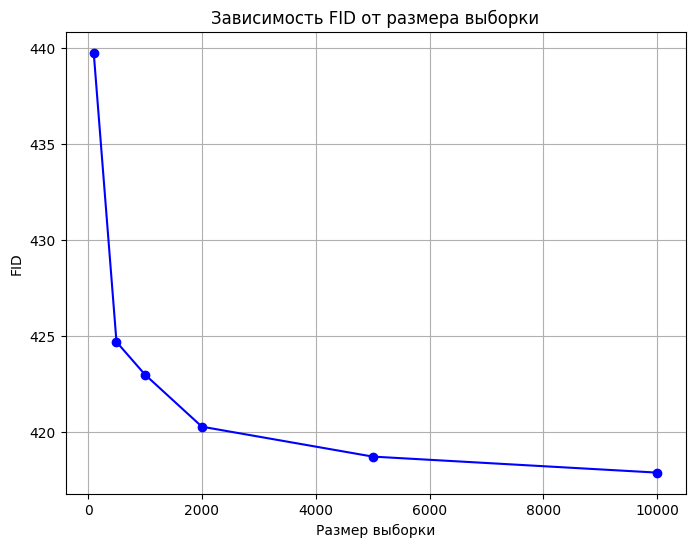

In [ ]:
import matplotlib.pyplot as plt
import os

path_dataset = "./mnist_data_img"
path_output  = "./mnist_gen_img"

# Размеры выборки
sample_sizes = [100, 500, 1000, 2000, 5000, 10000]

fid_values = []

# Цикл для расчета FID
for sample_size in sample_sizes:
    sampled_dataset_files = os.listdir(path_dataset)[:sample_size]
    sampled_output_files = os.listdir(path_output)[:sample_size]

    # Создал временные папки на всякий(боялся повредить файл)
    sampled_dataset_path = "./temp_dataset"
    sampled_output_path = "./temp_output"

    # Создаем временные папки
    os.makedirs(sampled_dataset_path, exist_ok=True)
    os.makedirs(sampled_output_path, exist_ok=True)

    # Копирование файлов во временные
    for file in sampled_dataset_files:
        os.system(f"cp {os.path.join(path_dataset, file)} {os.path.join(sampled_dataset_path, file)}")

    for file in sampled_output_files:
        os.system(f"cp {os.path.join(path_output, file)} {os.path.join(sampled_output_path, file)}")

    #FID для текущего размера выборки
    fid = calculate_fid_given_paths(
        [sampled_dataset_path, sampled_output_path],
        batch_size=100,
        device=device,
        dims=2048,
        num_workers=12
    )

    fid_values.append(fid)
    print(f"Размер выборки: {sample_size}, FID: {fid}")

    # Удаление папок
    os.system(f"rm -rf {sampled_dataset_path} {sampled_output_path}")

plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, fid_values, marker='o', linestyle='-', color='b')
plt.title("Зависимость FID от размера выборки")
plt.xlabel("Размер выборки")
plt.ylabel("FID")
plt.grid(True)
plt.show()

#Вывод
Вначале графика наблюдается резкое снижение FID от 440 до 425 при увеличении выборки с 100 до 500 изображений. Это может указывать на то, что на малых размерах выборки модель не получает достаточно информации для корректного семплирования, что приводит к высокому FID.

Начиная с выборок около 5000 изображений, график становится более пологим. Это говорит о том, что увеличение размера выборки начинает оказывать менее заметное влияние на качество, и модель уже начинает стабилизироваться в своей работе.
Возможность дальнейшего уменьшения FID:

Хотя к 10 000 изображений FID стабилизируется около значения 420, возможно, дальнейшее увеличение выборки может привести к ещё более низким значениям FID. Однако этот эффект может быть не столь значительным.

 Наиболее значительное улучшение качества происходит на малых выборках, когда модель получает больше информации для генерации.

 При больших выборках улучшение становится менее заметным, что говорит о том, что модель стабилизируется по мере накопления информации и данных.

 Этот график подтверждает, что использование большего количества данных помогает улучшить качество генерации изображений, однако увеличение выборки до бесконечности может не всегда приводить к значительному улучшению после определенного порога.